# Import Libraries

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c playground-series-s4e8

 94% 77.0M/82.3M [00:01<00:00, 91.4MB/s]
100% 82.3M/82.3M [00:01<00:00, 77.0MB/s]


In [ ]:
!pip install --upgrade catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.9 MB/s eta 0:00:00


In [ ]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
# https://www.kaggle.com/code/kirankunapuli/ieee-fraud-lightgbm-with-gpu/notebook

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import mode

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Loading Data

In [ ]:
!unzip /content/playground-series-s4e8.zip

Archive:  /content/playground-series-s4e8.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train_df = pd.read_csv("/content/train.csv", index_col='id')
orig_df = pd.read_csv("/content/secondary_data.csv", sep=";")
test_df = pd.read_csv("/content/test.csv", index_col='id')

In [ ]:
train_df = pd.concat([train_df, orig_df], ignore_index=True)

# EDA

In [ ]:
pd.DataFrame({
    'column': train_df.columns,
    'null-count': train_df.isna().sum().values,
    '% null-count': np.round(train_df.isna().sum().values*100/len(train_df),6)
}).sort_values(by='null-count', ascending=False).reset_index(drop=True)

,column,null-count,% null-count
0,veil-type,3015385,94.882685
1,spore-print-color,2904397,91.390315
2,stem-root,2808561,88.374721
3,veil-color,2794603,87.935516
4,stem-surface,2018985,63.529770
5,gill-spacing,1283498,40.386795
6,cap-surface,685143,21.558841
7,gill-attachment,533820,16.797283
8,ring-type,131351,4.133116
9,gill-color,57,0.001794


In [ ]:
train_df.duplicated().sum()

146

In [ ]:
train_df.drop_duplicates(inplace=True)

In [ ]:
target = 'class'

In [ ]:
features = train_df.drop(target, axis=1).columns.to_list()

In [ ]:
features_with_high_null_values = [feature for feature in features if (train_df[feature].isna().sum()/len(train_df)*100)>20]

In [ ]:
categorical_features = train_df[features].select_dtypes(include='object').columns.to_list()

In [ ]:
numerical_features = list(set(features) - set(categorical_features))

In [ ]:
pd.concat([train_df, test_df])[categorical_features].describe(include='O').T

,count,unique,top,freq
cap-shape,5255761,108,x,2420907
cap-surface,4123785,114,t,775813
cap-color,5255807,109,n,2288054
does-bruise-or-bleed,5255814,29,f,4333738
gill-attachment,4372220,117,a,1089691
gill-spacing,3132740,66,c,2242712
gill-color,5255726,86,w,1570803
stem-root,609261,45,b,279559
stem-surface,1915361,87,s,552131
stem-color,5255773,88,w,2016928


# Imputing Null Values

In [ ]:
categorical_impute_features = ['cap-surface' , 'gill-attachment' , 'ring-type']

In [ ]:
categorical_missing_features = list(set(categorical_features) - set(categorical_impute_features))

In [ ]:
def randomforest_impute(df, categorical_impute_features):
    # 각 열에 대해 반복적으로 결측치를 보간
    for col in categorical_impute_features:
        # 결측값이 있는 인덱스 저장
        missing_idx = df[df[col].isnull()].index

        # 레이블 인코더 딕셔너리 생성
        label_encoders = {}

        # 모든 범주형 열에 대해 레이블 인코딩 수행
        for feature in df.columns:
            if df[feature].dtype == 'object':
                label_encoders[feature] = LabelEncoder()
                df[feature] = label_encoders[feature].fit_transform(df[feature].astype(str))

        # 결측값이 있는 행과 없는 행 분리
        train = df.drop(index=missing_idx)  # 결측값이 없는 행
        test = df.loc[missing_idx]          # 결측값이 있는 행

        # 나머지 열을 입력 변수로 사용하여 학습
        X_train = train.drop(columns=[col])
        y_train = train[col]
        X_test = test.drop(columns=[col])

        # RandomForestClassifier를 사용해 보간
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)

        # 예측된 결측값으로 대체
        df.loc[missing_idx, col] = rf.predict(X_test)

        # 원래 범주형 값으로 복원
        df[col] = label_encoders[col].inverse_transform(df[col].astype(int))

    return df

# 함수 실행
train_df = randomforest_impute(train_df, categorical_impute_features)
test_df = randomforest_impute(test_df, categorical_impute_features)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# 랜덤 포레스트 기반 보간 함수 정의
def randomforest_impute(df, categorical_impute_features):
    label_encoders = {}
    for col in df.columns:
      if df[col].dtype == 'object':
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col].astype(str))  # NaN을 문자열로 처리
    for col in categorical_impute_features:
        # 결측값이 있는 행과 없는 행 분리
        train = df[df[col].notnull()]
        test = df[df[col].isnull()]

        # 나머지 열을 입력 변수로 사용하여 학습
        X_train = train.drop(columns=[col])
        y_train = train[col]
        X_test = test.drop(columns=[col])

        # RandomForestClassifier를 사용해 보간
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)

        # 예측된 결측값으로 대체
        df.loc[df[col].isnull(), col] = rf.predict(X_test)

    return df

# 결측값 보간
train_df = randomforest_impute(df, categorical_impute_features)

# 레이블 인코딩 된 데이터를 원래 범주형 값으로 복원
for col, encoder in label_encoders.items():
    train_df[col] = encoder.inverse_transform(train_df[col].astype(int))

In [25]:
def randomforest_impute(df, categorical_impute_features):
    # 각 열에 대해 반복적으로 결측치를 보간
    for col in categorical_impute_features:

        df.loc[df[col].value_counts(dropna=False)[df[col]].values < 100, col] = "noise"
        df[col] = df[col].astype('category')

        # 결측값이 있는 행과 없는 행 분리
        train = df[df[col].notnull()]
        test = df[df[col].isnull()]

        # 레이블 인코더 딕셔너리 생성
        label_encoders = {}

        # train 데이터의 범주형 열을 레이블 인코딩
        for feature in df.columns:
            if df[feature].dtype == 'object':
                label_encoders[feature] = LabelEncoder()
                # train 데이터 인코딩
                train[feature] = label_encoders[feature].fit_transform(train[feature].astype(str))
                # test 데이터 인코딩
                if feature != col:  # 목표 변수는 fit_transform을 하면 안 되므로 조건 추가
                    test[feature] = label_encoders[feature].transform(test[feature].astype(str))

        # 나머지 열을 입력 변수로 사용하여 학습
        X_train = train.drop(columns=[col])
        y_train = train[col]
        X_test = test.drop(columns=[col])

        # RandomForestClassifier를 사용해 보간
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)

        # 예측된 결측값으로 대체
        df.loc[df[col].isnull(), col] = label_encoders[col].inverse_transform(rf.predict(X_test))

    return df

train_df = randomforest_impute(train_df, categorical_impute_features)
test_df = randomforest_impute(test_df, categorical_impute_features)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# 나머지 범주형 열 처리
def cleaner(df, categorical_features):
    for col in categorical_features:
        df[col] = df[col].fillna('missing')
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < 100, col] = "noise"
        df[col] = df[col].astype('category')
    return df

train_df = cleaner(train_df, categorical_missing_features)
test_df = cleaner(test_df, categorical_missing_features)

In [ ]:
cap_diameter_mean = pd.concat([train_df['cap-diameter'], test_df['cap-diameter']]).mean(numeric_only=True)
train_df['cap-diameter'].fillna(cap_diameter_mean, inplace=True)
test_df['cap-diameter'].fillna(cap_diameter_mean, inplace=True)

# Model Training

In [ ]:
X = train_df.copy()
y = X.pop(target)

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [ ]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [ ]:
def model_trainer(model, X, y, n_splits=5, random_state=42):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof_probs, oof_mccs = [], []
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx]
        X_test, y_test = X.iloc[test_idx, :], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mcc = matthews_corrcoef(y_pred, y_test)
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df))
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
    print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

## Baseline Models

In [ ]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_report(xgb_clf, X, y)

    Model: XGBClassifier


KeyboardInterrupt: 

In [ ]:
cat_clf = CatBoostClassifier(
    cat_features=categorical_features,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)

model_report(cat_clf, X, y)

    Model: CatBoostClassifier


KeyboardInterrupt: 

    Model: LGBMClassifier
F1 Score : 0.991484
MCC Score: 0.981226


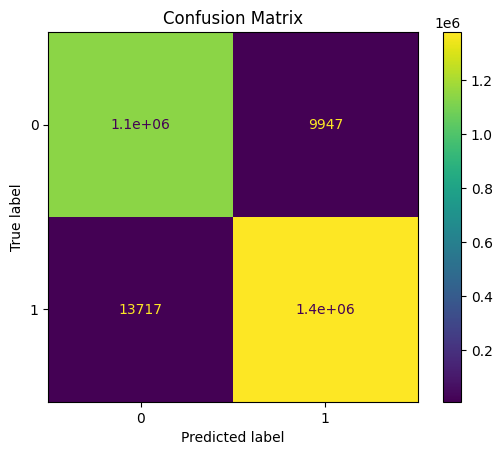

In [ ]:
lgb_clf = LGBMClassifier(device='gpu',verbosity=-1)

model_report(lgb_clf, X, y)

## Hyperparameter Tuning

In [ ]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_features
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
#     'device': 'gpu',
    'verbosity': -1
}

## Prediction

In [ ]:
oof_probs = {}
oof_probs['xgb'], _ = model_trainer(XGBClassifier(**xgb_params), X, y, random_state=101)
# oof_probs['cat'], _ = model_trainer(CatBoostClassifier(**cat_params), X, y, random_state=101)
# oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_params), X, y, random_state=101)

Training XGBClassifier


KeyboardInterrupt: 

In [ ]:
oof_preds = {}
for model in oof_probs.keys():
    oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis=0), axis=1)

# Submission

In [ ]:
sub = pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")
preds = [pred for model, pred in oof_preds.items()]
md = mode(preds, axis=0)[0] if len(preds)>1 else preds[0]
sub[target] = lab_enc.inverse_transform(md)
sub.to_csv("submission.csv", index=False)

In [ ]:
ext1 = pd.read_csv("/kaggle/input/mario-s-nightmare-15-th-place-solution/submission.csv")[target].ravel()
ext2 = pd.read_csv("/kaggle/input/ps4e8-binary-class-mathews-correlation-coeff/submission.csv")[target].ravel()
ext3 = pd.read_csv("/kaggle/input/playgrounds4e08-modeblend/submission.csv")[target].ravel()
ext4 = pd.read_csv("/kaggle/input/autogloun-t8-dslanders/submission.csv")[target].ravel()
ext5 = pd.read_csv("/kaggle/input/mario-s-nightmare-denselight-0-990/submission_test7.csv")[target].ravel()

In [ ]:
preds = [ext1, ext2, ext3, ext4, ext5]

preds = [lab_enc.transform(x) for x in preds]

In [ ]:
md = mode(preds, axis=0)[0]

In [ ]:
sub[target] = lab_enc.inverse_transform(md)
sub.to_csv("submission.csv", index=False)